# Computer Detection of Algal Blooms

In [8]:
import pandas as pd
import numpy as np
import os
import glob
import  PIL
from PIL import Image
import cv2
import time
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from data_cleaning import *
from keras import models
from keras import layers
%matplotlib inline

## Image Preprocessing

#### Find the minimum size of image in each folder

In [9]:
# this function exists in data-cleaning.py
test_algae = "split/test/algae/*"
test_not_algae = "split/test/not_algae/*"
get_img_stats(test_algae)
get_img_stats(test_not_algae)

train_algae = "split/train/algae/*"
train_not_algae = "split/train/not_algae/*"
get_img_stats(train_algae)
get_img_stats(train_not_algae)

val_algae = "split/validation/algae/*"
val_not_algae = "split/validation/not_algae/*"
get_img_stats(val_algae)
get_img_stats(val_not_algae)

images appended!
(140, 100)
images appended!
(160, 237)
images appended!
(140, 100)
images appended!
(153, 110)
images appended!
(140, 100)
images appended!
(200, 160)


### Image Augmentation

In [10]:
# reshape the images, flip, rotate and adjust brightness using Keras

# get all the data in the directory split/test (230 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=90, 
                                    brightness_range=[0.1,1.5], horizontal_flip=True).flow_from_directory(
    'split/test/', target_size=(140, 140),batch_size = 291)# class_mode='binary')
# get all the data in the directory split/train (570 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255,rotation_range=90, 
                                     brightness_range=[0.2,1.5], horizontal_flip=True).flow_from_directory(
    'split/train/', target_size=(140, 140), batch_size=871) #class_mode='binary')

# get all the data in the directory split/validation (160 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255,  rotation_range=90, 
                                   brightness_range=[0.2,1.5], horizontal_flip=True).flow_from_directory(
    'split/validation/', target_size=(140, 140), batch_size = 294) #class_mode='binary')

Found 288 images belonging to 2 classes.
Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


#### Tweaks 
For image augmentation, I tried a few different things. I ran an initial model and then made some of the tweaks listed below.

* Shape:
    * I tried the true minimum, 140x100, but most of the images were distorted
    * To improve my model I decided on 140x140 square image to see if it distorted the images less
    
* Scaling: 
    * The new images size was still very blurry so I tried to tweak the rescaling
    * I also tried rescaling at 1./255 and NO rescaling
    * The no rescaling did not help and made the images much more blurry


* Brightness:
    * I initially had the brightness set to a range of 0.2 - 1.0. This range randomly darkened the images only
    * I adjusted the brightness generator to randomly generate light and dark images by changing the range to 0.2 - 1.5. 
    * This last step helped a lot when viewing the images

These changes resulted in an increase in a pretty minimal (<0.5%) greater predicting accuracy on the test set.

#### Create Data Labels 

In [11]:
# split images and labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [12]:
images = np.concatenate((train_images, test_images, val_images))
labels = np.concatenate((train_labels[:,0], test_labels[:,0], val_labels[:,0]))

In [13]:
# lets check our dataset numbers again post-reshaping 
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 867
Number of testing samples: 288
Number of validation samples: 291
train_images shape: (867, 140, 140, 3)
train_labels shape: (867, 2)
test_images shape: (288, 140, 140, 3)
test_labels shape: (288, 2)
val_images shape: (291, 140, 140, 3)
val_labels shape: (291, 2)


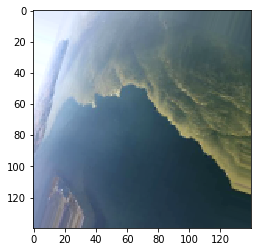

In [61]:
# show one of the images
plt.imshow(images[16])
plt.show()

#### Split train, test, and val into X & Y 

In [14]:
# split into x & y and check shape
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print("Train X:", train_img.shape)
print("Test X:", test_img.shape)
print("Val X:", val_img.shape)

train_y = np.reshape(train_labels[:,0], (867,1))
test_y = np.reshape(test_labels[:,0], (288,1))
val_y = np.reshape(val_labels[:,0], (291,1))

print("\n")
print("Train y:", train_y.shape)
print("Test y:", test_y.shape)
print("Val y:", val_y.shape)

Train X: (867, 58800)
Test X: (288, 58800)
Val X: (291, 58800)


Train y: (867, 1)
Test y: (288, 1)
Val y: (291, 1)


## Build a Convolutional Neural Network (CNN)

### Model # 1

In [34]:
# instantiate the model 
base_model = models.Sequential()

base_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(140, 140,  3)))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [38]:
history = model.fit(train_images,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Train on 867 samples, validate on 291 samples
Epoch 1/20
867/867 [==============================] - 20s 23ms/step - loss: 0.4395 - acc: 0.8108 - val_loss: 0.4235 - val_acc: 0.8076
Epoch 2/20
867/867 [==============================] - 18s 21ms/step - loss: 0.4128 - acc: 0.8235 - val_loss: 0.4114 - val_acc: 0.8007
Epoch 3/20
867/867 [==============================] - 18s 21ms/step - loss: 0.4179 - acc: 0.8131 - val_loss: 0.3626 - val_acc: 0.8522
Epoch 4/20
867/867 [==============================] - 18s 21ms/step - loss: 0.4204 - acc: 0.8120 - val_loss: 0.5660 - val_acc: 0.7423
Epoch 5/20
867/867 [==============================] - 18s 21ms/step - loss: 0.4449 - acc: 0.7947 - val_loss: 0.4865 - val_acc: 0.7457
Epoch 6/20
867/867 [==============================] - 18s 21ms/step - loss: 0.4246 - acc: 0.8108 - val_loss: 0.7626 - val_acc: 0.6460
Epoch 7/20
867/867 [==============================] - 18s 21ms/step - loss: 0.4165 - acc: 0.8166 - val_loss: 0.6234 - val_acc: 0.6907
Epoch 8/20
867/8

In [39]:
results_train = model.evaluate(train_images, train_y)
results_train

867/867 [==============================] - 4s 4ms/step


[0.3829137596979548, 0.8339100480079651]

In [40]:
results_test = model.evaluate(test_images, test_y)
results_test

288/288 [==============================] - 1s 4ms/step


[0.5321037934886085, 0.7951388955116272]

* first results (epochs = 30:
    * 90% loss
    * about 65% accuracy
* second results (more epochs - 60):
    * 35% loss 
    * 80% accuracy
    * roughly 1% difference between test and validation sets
* third results (epochs = 15 + changes mentioned a few cells up): 
    * test results are 49% loss and 79.16% accuracy
    * train accuracy is 80% and val is 83%
* fourth results (increase to epochs = 20 with no other major changes): 
    * test results are 53% loss and 79.5% accuracy
    * train accuracy is 83%
    * test and validation accuracy scores on last epoc are 83.6% and 83.5% respectively so this hopefully means no overfitting!

In [ ]:
# check labels for classes 
# can a human label them easily?
# waht are the standards and accuracy for satellite traininng of models?
# for whom? 
# find image standard and demo with that image 

In [ ]:
# Model improvements 

# manually crop images, increase saturation or contrast 
# fix scale? some images are quished, increase size 
# inception resnet
# add more layers 